In [1]:
# Imports

import pickle

import my_factor_tools
from my_factor_tools import *

import matcouply
from matcouply.penalties import NonNegativity,Parafac2
from matcouply.decomposition import cmf_aoadmm

import tqdm.notebook as tqdm

In [2]:
# Choose case to try:
# "1": Smooth PARAFAC2 data
# "2": Non-PARAFAC2 smooth data
# "3a": Incorporating prior information - Orthogonal H
# "3b": Incorporating prior information - Non-orthogonal H

case = "1"

In [3]:
# Noise strength eta, where: X_noisy = X + eta * ||X|| (noise/||noise||)
noise_level = 0.75

In [4]:
# If seed is between 0 and 29 and noise level is in [0.25,0.75,1.25],
# one of the datasets used in the experiments will be used.
# Otherwise, a random dataset will be generated.

seed = 0

if seed <= 29 and noise_level in [0.25,0.75,1.25]:

    # Read one of the datasets used in the experiments
    
    with open(f'exp{case}_input/dataset{seed}_noise{str(noise_level)}.pkl', 'rb') as f:
        input = pickle.load(f)

    noisy_tensor = input['tensor']
    gnd_A = input['A']
    gnd_B = input['B']
    gnd_C = input['C']
    if "H" in input.keys():
        gnd_H = input['H']

else:

    # Generate a new one of the "case" case

    if case == "1":
        tensor, gnd_A , gnd_B, gnd_C = my_factor_tools.create_random_smooth_parafac2_tensor((40, 50, 30), 3, seed)
    elif case == "2":
        tensor, gnd_A , gnd_B, gnd_C = generate_non_parafac2_tensor((40, 50, 30), 3, seed)
    elif case == "3a":
        tensor, gnd_A , gnd_B, gnd_C, gnd_H = create_ortho_tensor_H((40, 50, 30), 3, seed)
    elif case == "3b":
        tensor, gnd_A , gnd_B, gnd_C, gnd_H = generate_non_ortho_dataset((40, 50, 30), 3, seed)
    else:
        print("Invalid case")

    # add noise to the formed tensor
    noise_tensor = np.random.normal(0,1,tensor.shape)
    noisy_tensor = tensor + noise_level * ((tl.norm(tensor))/(tl.norm(noise_tensor))) * noise_tensor

In [5]:
# Choose model to use from "parafac2","tparafac2","dCMF_I","dCMF_H"
# TODO: Change the regs and l2_penalty accoridng to the model used

model = 'dCMF_I'
l_B = 10

if model == 'parafac2':
    regs = [[NonNegativity()],[Parafac2()],[]]
    l2_penalty = [None,None,None]
elif model == 'tparafac2':
    regs = [[NonNegativity()],[Parafac2(),my_factor_tools.myTemporalSmoothnessPenalty(smoothness_l=l_B)],[]]
    l2_penalty = [0.001,0,0.001]
elif model == 'dCMF_I':
    regs = [[NonNegativity()],[my_factor_tools.myTemporallyPenalty(smoothness_l=l_B,H=np.eye(gnd_B[0].shape[0]),verify=False)],[]]
    l2_penalty = [0.001,0,0.001]
elif model == 'dCMF_H':
    regs = [[NonNegativity()],[my_factor_tools.myTemporallyPenalty(smoothness_l=l_B,H=gnd_H,verify=False)],[]]
    l2_penalty = [0.001,0,0.001]

In [6]:
# Fit 10 initializations of the model

factors = []
diagntostics = []

for i in tqdm.tqdm(range(10)):
    (weights,(D,B,A)),run_diagnostics = cmf_aoadmm(
        matrices=noisy_tensor.T,
        rank=3,
        return_errors = True,
        n_iter_max=6000,
        l2_penalty=l2_penalty, # defined in the previous cell!
        regs=regs, # defined in the previous cell!
        # verbose=250,
        tol=1e-4,
        inner_n_iter_max=50,
        absolute_tol=1e-4,
        feasibility_tol=1e-5,
        inner_tol=1e-5,
    )

    if my_factor_tools.check_degenerate((D,B,A)):
        continue
    else:
        fms = my_factor_tools.get_fms((D,B,A), [gnd_C, gnd_B, gnd_A])
        print(f"FMS: {fms:.2f}")
        factors.append((A,B,D))
        diagntostics.append(run_diagnostics)

  0%|          | 0/10 [00:00<?, ?it/s]

FMS: 0.98
FMS: 0.98
FMS: 0.98
FMS: 0.98
FMS: 0.98
FMS: 0.98
FMS: 0.98
FMS: 0.98
FMS: 0.98
FMS: 0.98


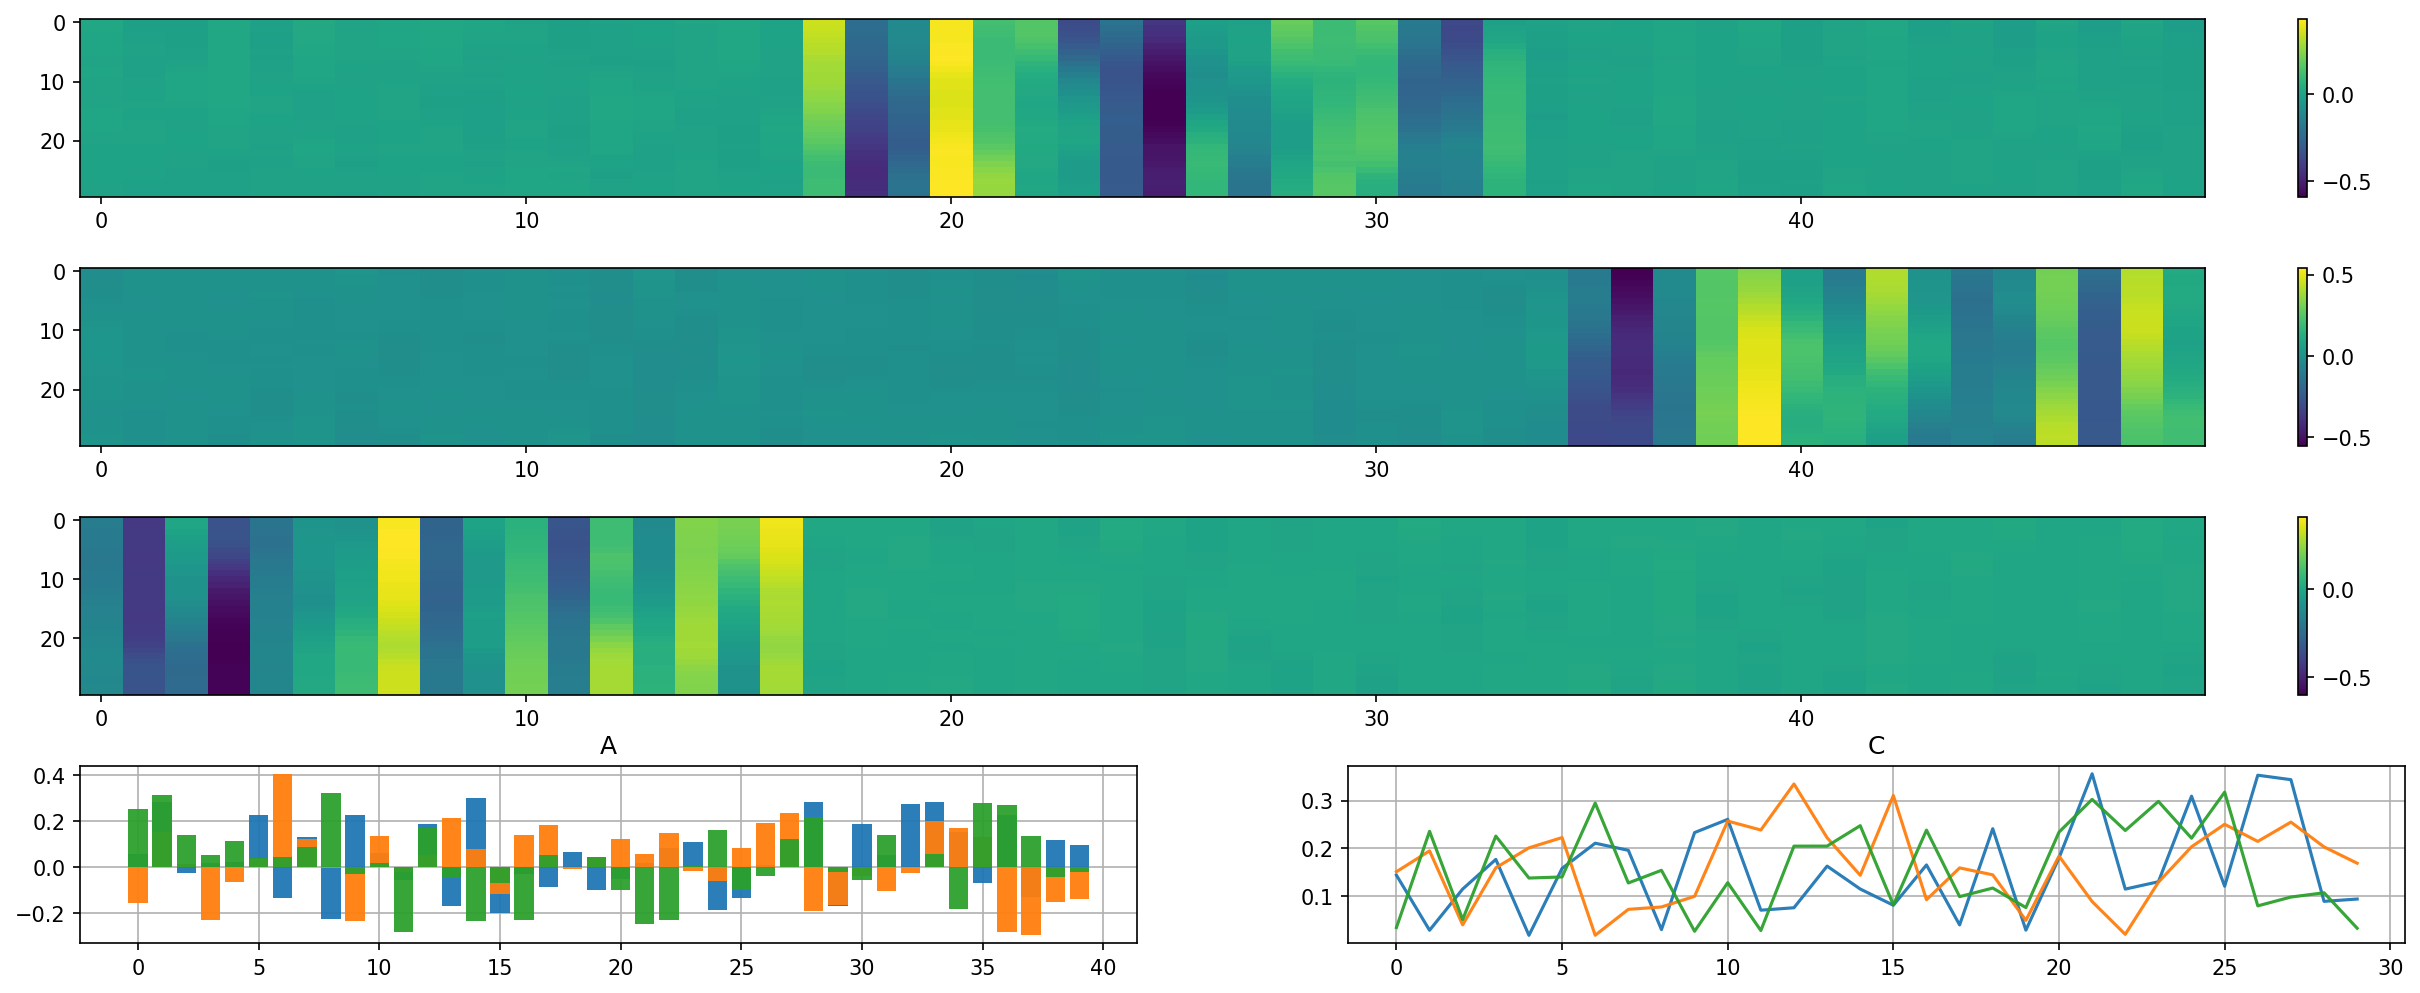

In [7]:
# Choose the best run (according to total loss) and plot the computed factors

best_run_index = np.argmin([d.regularized_loss[-1] for d in diagntostics])
best_run_factors = factors[best_run_index]

my_factor_tools.plot_factors(best_run_factors)